**Gradient boost machine from scratch**

References: https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

https://github.com/groverpr/Machine-Learning/blob/master/notebooks/01_Gradient_Boosting_Scratch.ipynb

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from fastai.imports import *
from IPython.display import display
from sklearn import metrics
import matplotlib as mlt
mlt.rcParams.update({'figure.max_open_warning': 0})

Helper function for STD

In [2]:
def std_agg(cnt, s1, s2): 
  return math.sqrt((s2/cnt) - (s1/cnt)**2)

Decision Tree from scratch. Creates a single decision tree with provided minimum sample leaf

In [3]:
class DecisionTree():
    def __init__(self, x, y, idxs = None, min_leaf=2):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

Simulate Data: random distribution

In [4]:
x = np.arange(0,100)
x = pd.DataFrame({'x':x})

y1 = np.random.uniform(20,25,20)
y2 = np.random.uniform(30,25,20)
y3 = np.random.uniform(0,5,20)
y4 = np.random.uniform(40,32,20)
y5 = np.random.uniform(23,17,20)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None]

Check data

In [5]:
x.shape, y.shape

((100, 1), (100, 1))

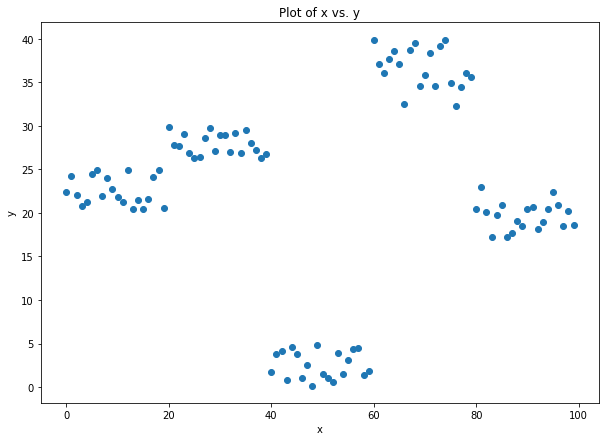

In [6]:
plt.figure(figsize=(10,7))
plt.plot(x,y, 'o')
plt.title("Plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Helper function to plot each iteration

In [7]:
def plot_iteration(x, y, i, ei):
  xa = np.array(x.x) # column name of x is x 
  order = np.argsort(xa)
  xs = np.array(xa)[order]
  ys = np.array(predf)[order]
    
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

  ax1.plot(x,y, 'o')
  ax1.plot(xs, ys, 'r')
  ax1.set_title(f'Prediction (Iteration {i+1})')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y / y_pred')

  ax2.plot(x, ei, 'go')
  ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
  ax2.set_xlabel('x')
  ax2.set_ylabel('Residuals')

Gradient Boost, based on Decision Tree

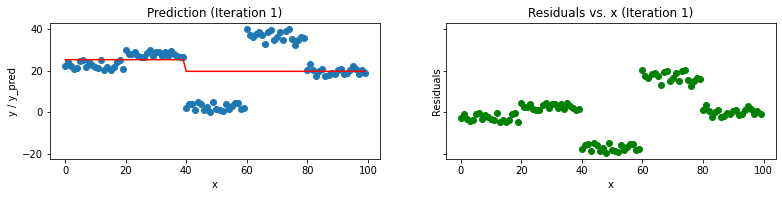

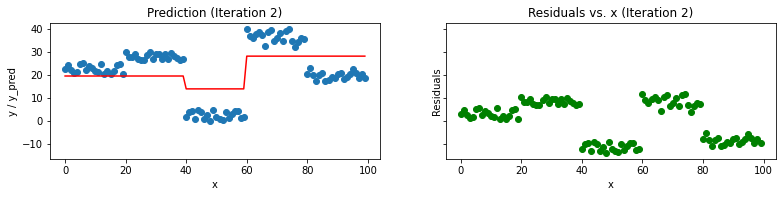

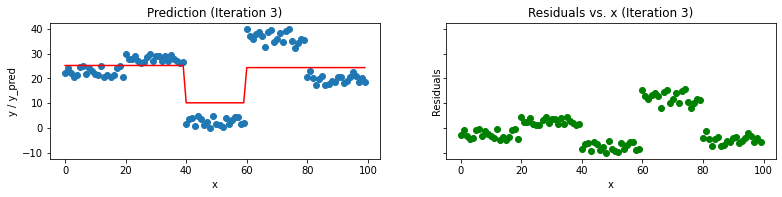

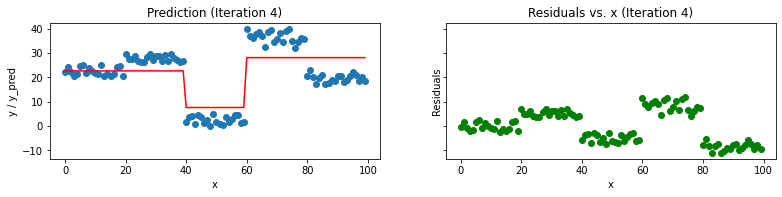

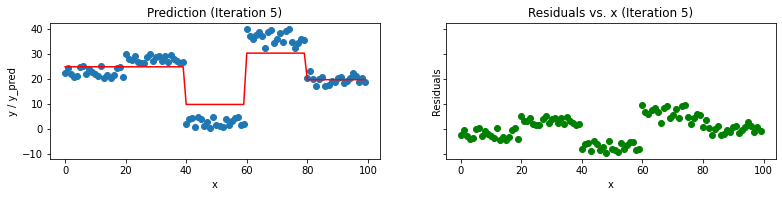

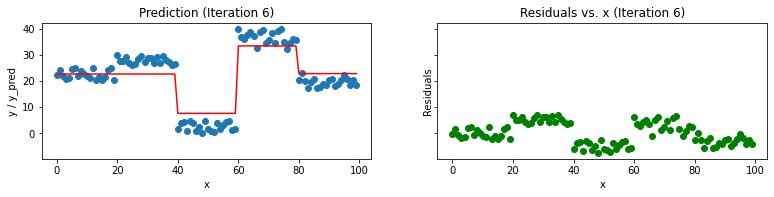

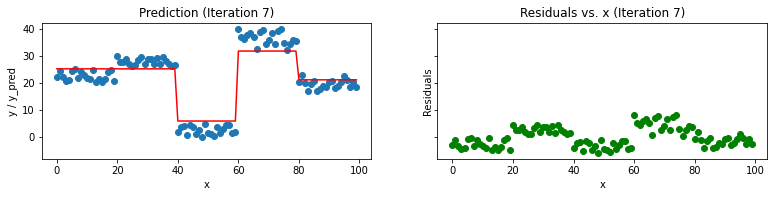

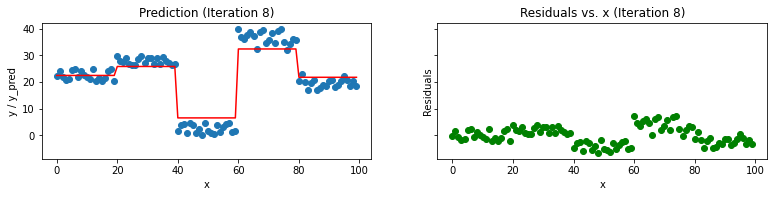

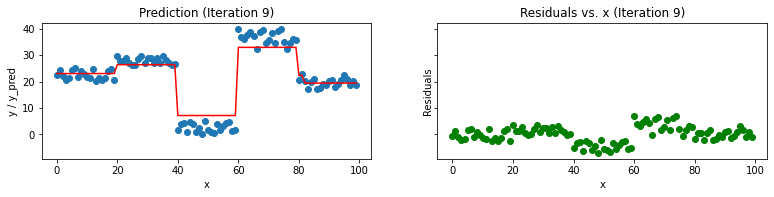

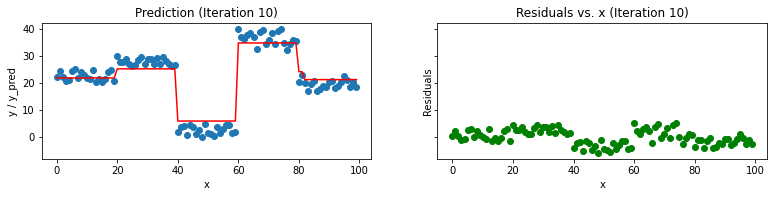

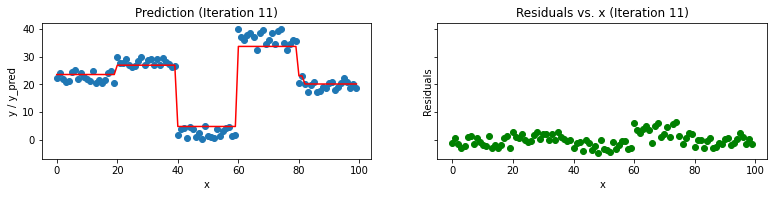

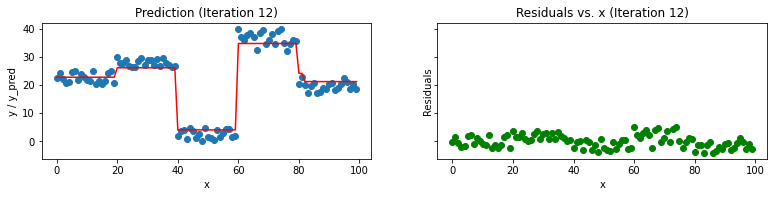

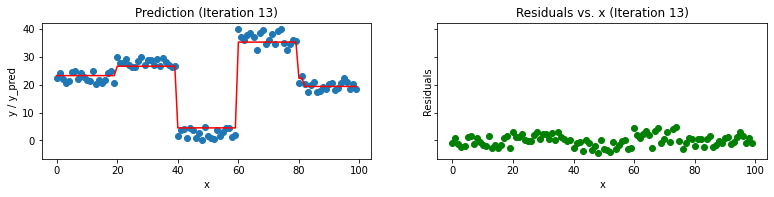

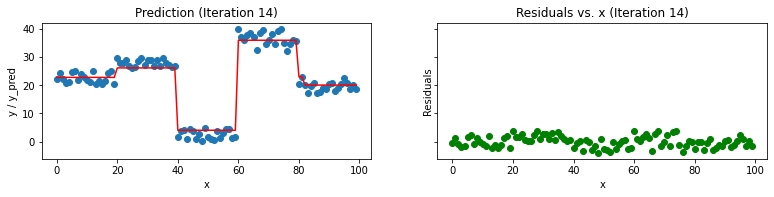

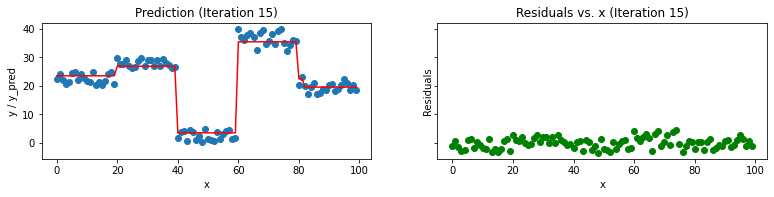

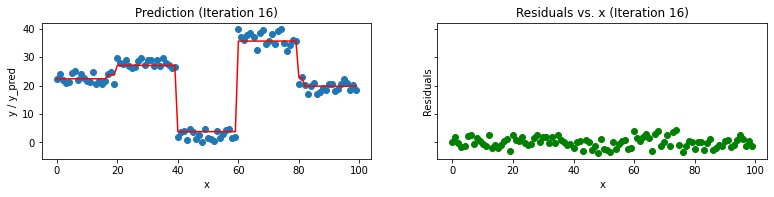

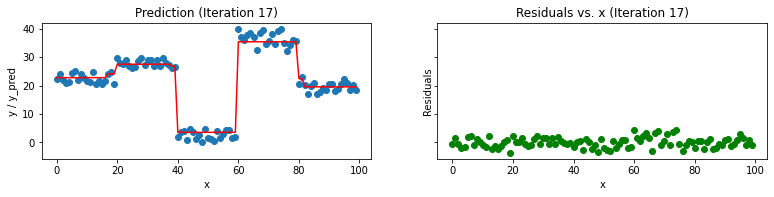

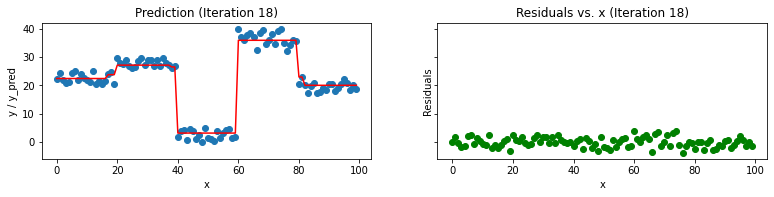

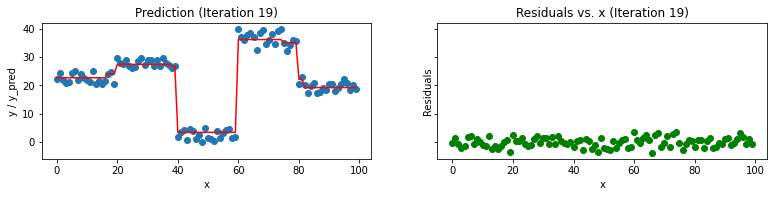

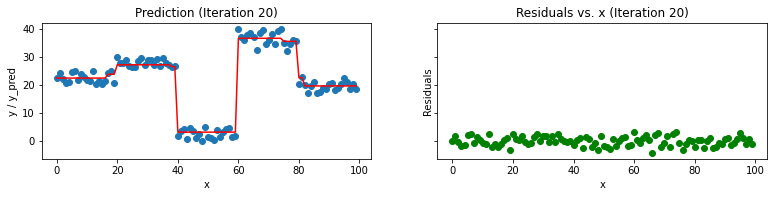

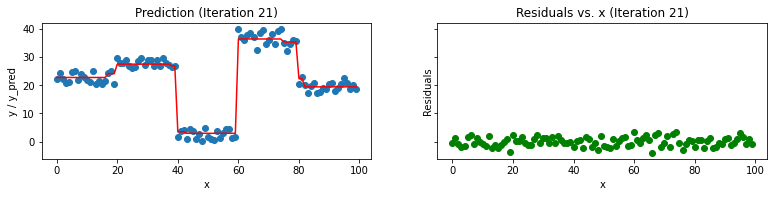

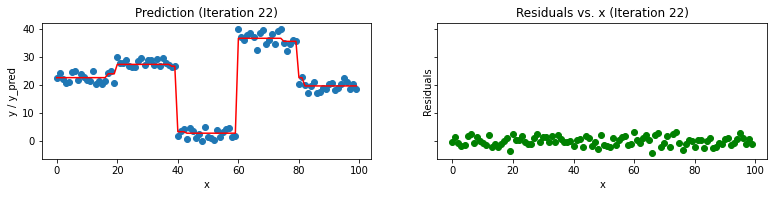

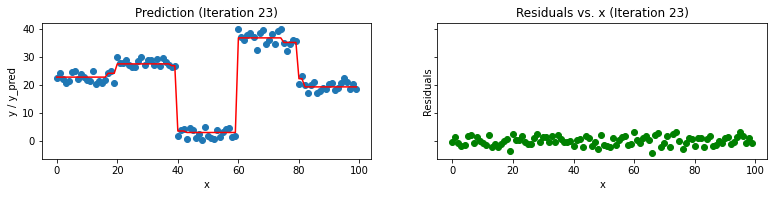

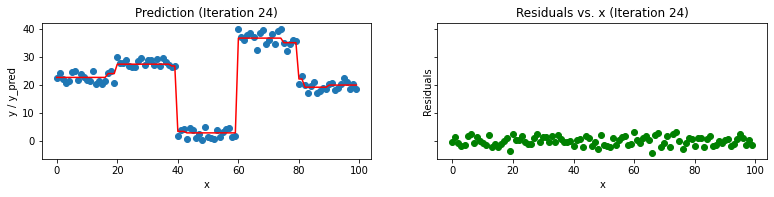

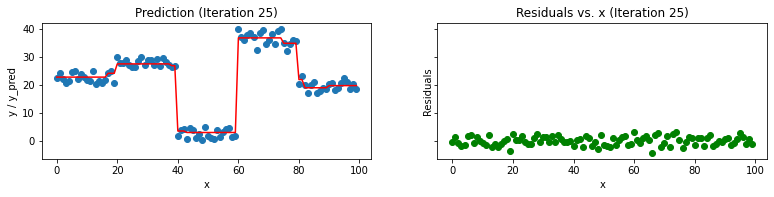

In [8]:
xi = x # initialize x
yi = y # initialize y
ei = 0 # initialize error
n = len(yi) 
predf = 0 # initial prediction  = 0

for i in range(25): # number of iterations. 
    tree = DecisionTree(xi,yi) # create decision tree
    tree.find_better_split(0)  # splits (<n and >n) data so that std. deviation of 
                               # label in both splits is minimum as compared to all other splits
    
    r = np.where(xi == tree.split)[0][0]   #  finds index where this best split occurs
    
    left_idx = np.where(xi <= tree.split)[0] # left index of split
    right_idx = np.where(xi > tree.split)[0] # right index of split
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # create vector (nx1) compatible with y
    predf = predf + predi  # prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # residual is always from original y    
    yi = ei # update yi as residual for next iteration
    
    # visualize at each iteration
    plot_iteration(x, y, i, ei)